In [1]:
import os
import shutil
import warnings

import numpy as np
import pandas as pd
import torchaudio

warnings.filterwarnings(action="ignore")
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import json

import geopandas
import librosa
import librosa.display
import matplotlib.pyplot as plt
import scipy.stats as st
import soundfile
import tensorflow as tf
import torch

%matplotlib inline
from PIL import Image
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

In [2]:
import os

import librosa
import numpy as np
import torch
import torchaudio
from PIL import Image
from tensorflow import keras

In [3]:
class Mel_Provider:
    def __init__(
        self,
        n_fft,
        win_length,
        n_mels,
        sample_rate,
        mel_image_size,
        min_frequency,
        max_frequency,
        signal_lenght,
        hop_length=None,
        norm_mel=True,
        device="cpu",
    ):
        self.norm_mel = norm_mel
        self._device = device
        self.signal_lenght = signal_lenght
        self.sample_rate = sample_rate
        self.mel_image_size = mel_image_size
        if hop_length is None:
            self.hop_length = int(
                self.signal_lenght * self.sample_rate / (self.mel_image_size - 1)
            )
        else:
            self.hop_length = hop_length
        self._melspectrogram = torchaudio.transforms.MelSpectrogram(
            power=2.0,
            center=True,
            norm="slaney",
            onesided=True,
            win_length=win_length,
            pad_mode="reflect",
            n_fft=n_fft,
            n_mels=n_mels,
            sample_rate=sample_rate,
            hop_length=self.hop_length,
            f_min=min_frequency,
            f_max=max_frequency,
        ).to(self._device)

    def msg(self, wave):
        wave = torch.tensor(wave.reshape([1, -1]).astype(np.float32)).to(self._device)
        mel_spec = self._melspectrogram(wave)[0].cpu().numpy()
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        if self.norm_mel:
            mel_spec = (mel_spec - np.min(mel_spec)) / (
                np.max(mel_spec) - np.min(mel_spec)
            )

        mel_spec.astype(np.float32)
        return mel_spec

In [13]:
class MEL_Generator(keras.utils.Sequence):
    def __init__(
        self,
        df,
        n_mels,
        sample_rate,
        mel_image_size,
        signal_lenght,
        n_classes,
        seed,
        mel_provider=Mel_Provider,
        convert_to_rgb=True,
        wave_dir=None,
        long_mel_dir=None,
        short_mel_dir=None,
        batch_size=32,
        shuffle=True,
        augmentation=None,
        sample_weight=True,
        device="cpu",
    ):
        self.mel_provider = mel_provider
        self.df = df.reset_index(drop=True)
        self.n_mels = n_mels
        self.sample_rate = sample_rate
        self.mel_image_size = mel_image_size
        self.signal_lenght = signal_lenght
        self.wave_dir = wave_dir
        self.long_mel_dir = long_mel_dir
        self.short_mel_dir = short_mel_dir
        self.convert_to_rgb = convert_to_rgb
        self.batch_size = batch_size
        self._shuffle = shuffle
        self.n_classes = n_classes
        self._device = device
        self.seed = seed

        if self._shuffle:
            self._shuffle_samples()

    if not os.path.exists('/app/_data/npy/short_mels_test/'):
        os.mkdir('/app/_data/npy/short_mels_test/')
    def __len__(self):
        return self.df.shape[0] // self.batch_size

    def long_msg(
        self,
        wave,
        file_name,
        save_mel=True,
    ):
        long_mel_dir = self.long_mel_dir
        if long_mel_dir is not None:
            if os.path.isfile(long_mel_dir + file_name + ".npy"):
                mel_spec = np.load(long_mel_dir + file_name + ".npy")
            else:
                mel_spec = self.mel_provider.msg(wave)
        else:
            mel_spec = self.mel_provider.msg(wave)
        if long_mel_dir is not None and save_mel:
            if not os.path.isfile(long_mel_dir + file_name + ".npy"):
                if not os.path.exists(long_mel_dir):
                    os.mkdir(long_mel_dir)
                np.save(long_mel_dir + file_name, mel_spec)
        return mel_spec

    def get_audio(
        self,
        file_path,
    ):
        wave_dir = self.wave_dir
        file_name = file_path.split("/")[-1][:-4]

        if wave_dir is not None:
            if os.path.isfile(wave_dir + file_name + ".npy"):
                wave = np.load(wave_dir + file_name + ".npy")
            else:
                wave, sr = librosa.load(file_path, sr=self.sample_rate)
        else:
            wave, sr = librosa.load(file_path, sr=self.sample_rate)
        if wave_dir is not None:
            if not os.path.isfile(wave_dir + file_name + ".npy"):
                if not os.path.exists(wave_dir):
                    os.mkdir(wave_dir)
                np.save(wave_dir + file_name, wave)
        return wave, file_name

    def on_epoch_start(self):
        if self._shuffle:
            self._shuffle_samples()

    def __getitem__(self, batch_ix):
        b_X = np.zeros(
            (self.batch_size, self.mel_image_size, self.mel_image_size, 3),
            dtype=np.uint8,
        )

        b_Y = np.zeros(
            (self.batch_size, self.n_classes),
            dtype=np.uint8,
        )

        for i in range(self.batch_size):
            b_X[i] = self._get_one(
                i + self.batch_size * batch_ix,
            )["mel_spec"]
            b_Y[i] = self._get_one(
                i + self.batch_size * batch_ix,
            )["y"]

        return b_X, b_Y

    def _get_one(self, ix):

        file_path = self.df.loc[ix, "file_path"]
        label_id = self.df.loc[ix, "label_id"]
        end_sec = self.df.loc[ix, "end_sec"]
        file_name = self.df.loc[ix, "filename"][:-4]
        new_filename = self.df.loc[ix, "row_id"]
        start_sec = end_sec - 5
        if os.path.isfile(self.short_mel_dir + new_filename + ".npy"):
            mel_spec = np.load(self.short_mel_dir + new_filename + ".npy")
            long_mel_spec = np.load(self.long_mel_dir + file_name + ".npy")
        else:
            if os.path.isfile(self.long_mel_dir + file_name + ".npy"):
                long_mel_spec = np.load(self.long_mel_dir + file_name + ".npy")

            else:
                wave, filename = self.get_audio(
                    file_path,
                )
                long_mel_spec = self.long_msg(wave, filename, save_mel=True)

            start = int((start_sec * self.mel_image_size) / self.signal_lenght)
            mel_spec = long_mel_spec[:, start : start + self.mel_image_size]

            if mel_spec.shape != (self.mel_image_size, self.mel_image_size):
                mel_spec = Image.fromarray(mel_spec)
                mel_spec = mel_spec.resize(
                    (self.mel_image_size, self.mel_image_size),
                    Image.BICUBIC,
                )
                mel_spec=np.array(mel_spec)

            if self.convert_to_rgb:
                mel_spec = np.round(mel_spec * 255)
                mel_spec = np.repeat(np.expand_dims(mel_spec.astype(np.uint8), 2), 3, 2)
            np.save(self.short_mel_dir + new_filename, mel_spec)
        y = np.zeros(self.n_classes, "uint8")
        y[label_id] = 1
        assert mel_spec.shape == (self.n_mels, self.mel_image_size, 3) or (
            self.n_mels,
            self.mel_image_size,
        )
        return {"mel_spec": mel_spec, "y": y, "long_mel_spec": long_mel_spec}

    def _shuffle_samples(self):
        self.df = self.df.sample(frac=1, random_state=self.seed).reset_index(drop=True)

In [14]:
data = pd.read_csv("/app/_data/labels_nocall/all_calls_1s.csv")

In [15]:
data["label_id"] = 0

In [16]:
data["file_path"]

0        /app/_data/birdclef-2021/train_soundscapes/112...
1        /app/_data/birdclef-2021/train_soundscapes/112...
2        /app/_data/birdclef-2021/train_soundscapes/112...
3        /app/_data/birdclef-2021/train_soundscapes/112...
4        /app/_data/birdclef-2021/train_soundscapes/112...
                               ...                        
25534    /app/_data/birdclef-2021/train_short_audio/ame...
25535    /app/_data/birdclef-2021/train_short_audio/ame...
25536    /app/_data/birdclef-2021/train_short_audio/ame...
25537    /app/_data/birdclef-2021/train_short_audio/ame...
25538    /app/_data/birdclef-2021/train_short_audio/ame...
Name: file_path, Length: 25539, dtype: object

In [17]:
data["file_path"] = data["file_path"].str.replace("birdclef-2021/", "")

In [18]:
SEED = 42
IMG_SIZE = 260
SAMPLE_RATE = 32000
N_FFT = 2048
SIGNAL_LENGTH = 5  # seconds
FREQ_MIN = 0
FREQ_MAX = 16000
WIN_LENGHT = 1024
AUDIO_PATH = "/app/_data/train_short_audio/"
BATCH_SIZE = 10

In [19]:
ms = Mel_Provider(
    n_fft=N_FFT,
    win_length=WIN_LENGHT,
    n_mels=IMG_SIZE,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    min_frequency=FREQ_MIN,
    max_frequency=FREQ_MAX,
    signal_lenght=SIGNAL_LENGTH,
)

In [20]:
gen = MEL_Generator(
    df=data,
    n_mels=IMG_SIZE,
    seed=SEED,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    n_classes=3,
    signal_lenght=SIGNAL_LENGTH,
    mel_provider=ms,
    wave_dir="/app/_data/npy/waves_npy_test/",
    long_mel_dir="/app/_data/npy/long_mels_test/",
    short_mel_dir="/app/_data/npy/short_mels_test/",
    convert_to_rgb=True,
    shuffle=False,
)

In [21]:
a = gen.__getitem__(39)

In [115]:
for j in range(100, 110):
    a = gen.__getitem__(j)
    for i in range(10):
        print(a[0][i].min(), a[0][i].max())

0 243
0 243
0 238
0 238
0 237
0 238
0 238
0 239
0 237
0 240
0 240
0 240
0 240
0 240
0 240
0 238
0 238
0 235
0 235
0 235
0 242
0 242
0 242
0 242
0 242
0 242
0 242
0 242
0 242
0 238
0 238
0 238
0 240
0 240
0 240
0 240
0 240
0 239
0 239
0 239
0 239
0 237
0 235
0 245
0 245
0 245
0 237
0 237
0 237
0 243
0 243
0 240
0 240
0 255
0 255
0 213
0 213
0 213
0 213
0 213
0 215
0 215
0 215
0 215
0 215
0 203
0 209
0 212
0 212
0 212
0 212
0 212
0 208
0 208
0 208
0 208
0 208
0 208
0 213
0 213
0 213
0 213
0 213
0 210
0 216
0 216
0 221
0 221
0 221
0 221
0 218
0 228
0 228
0 228
0 228
0 228
0 219
0 217
0 211
0 211


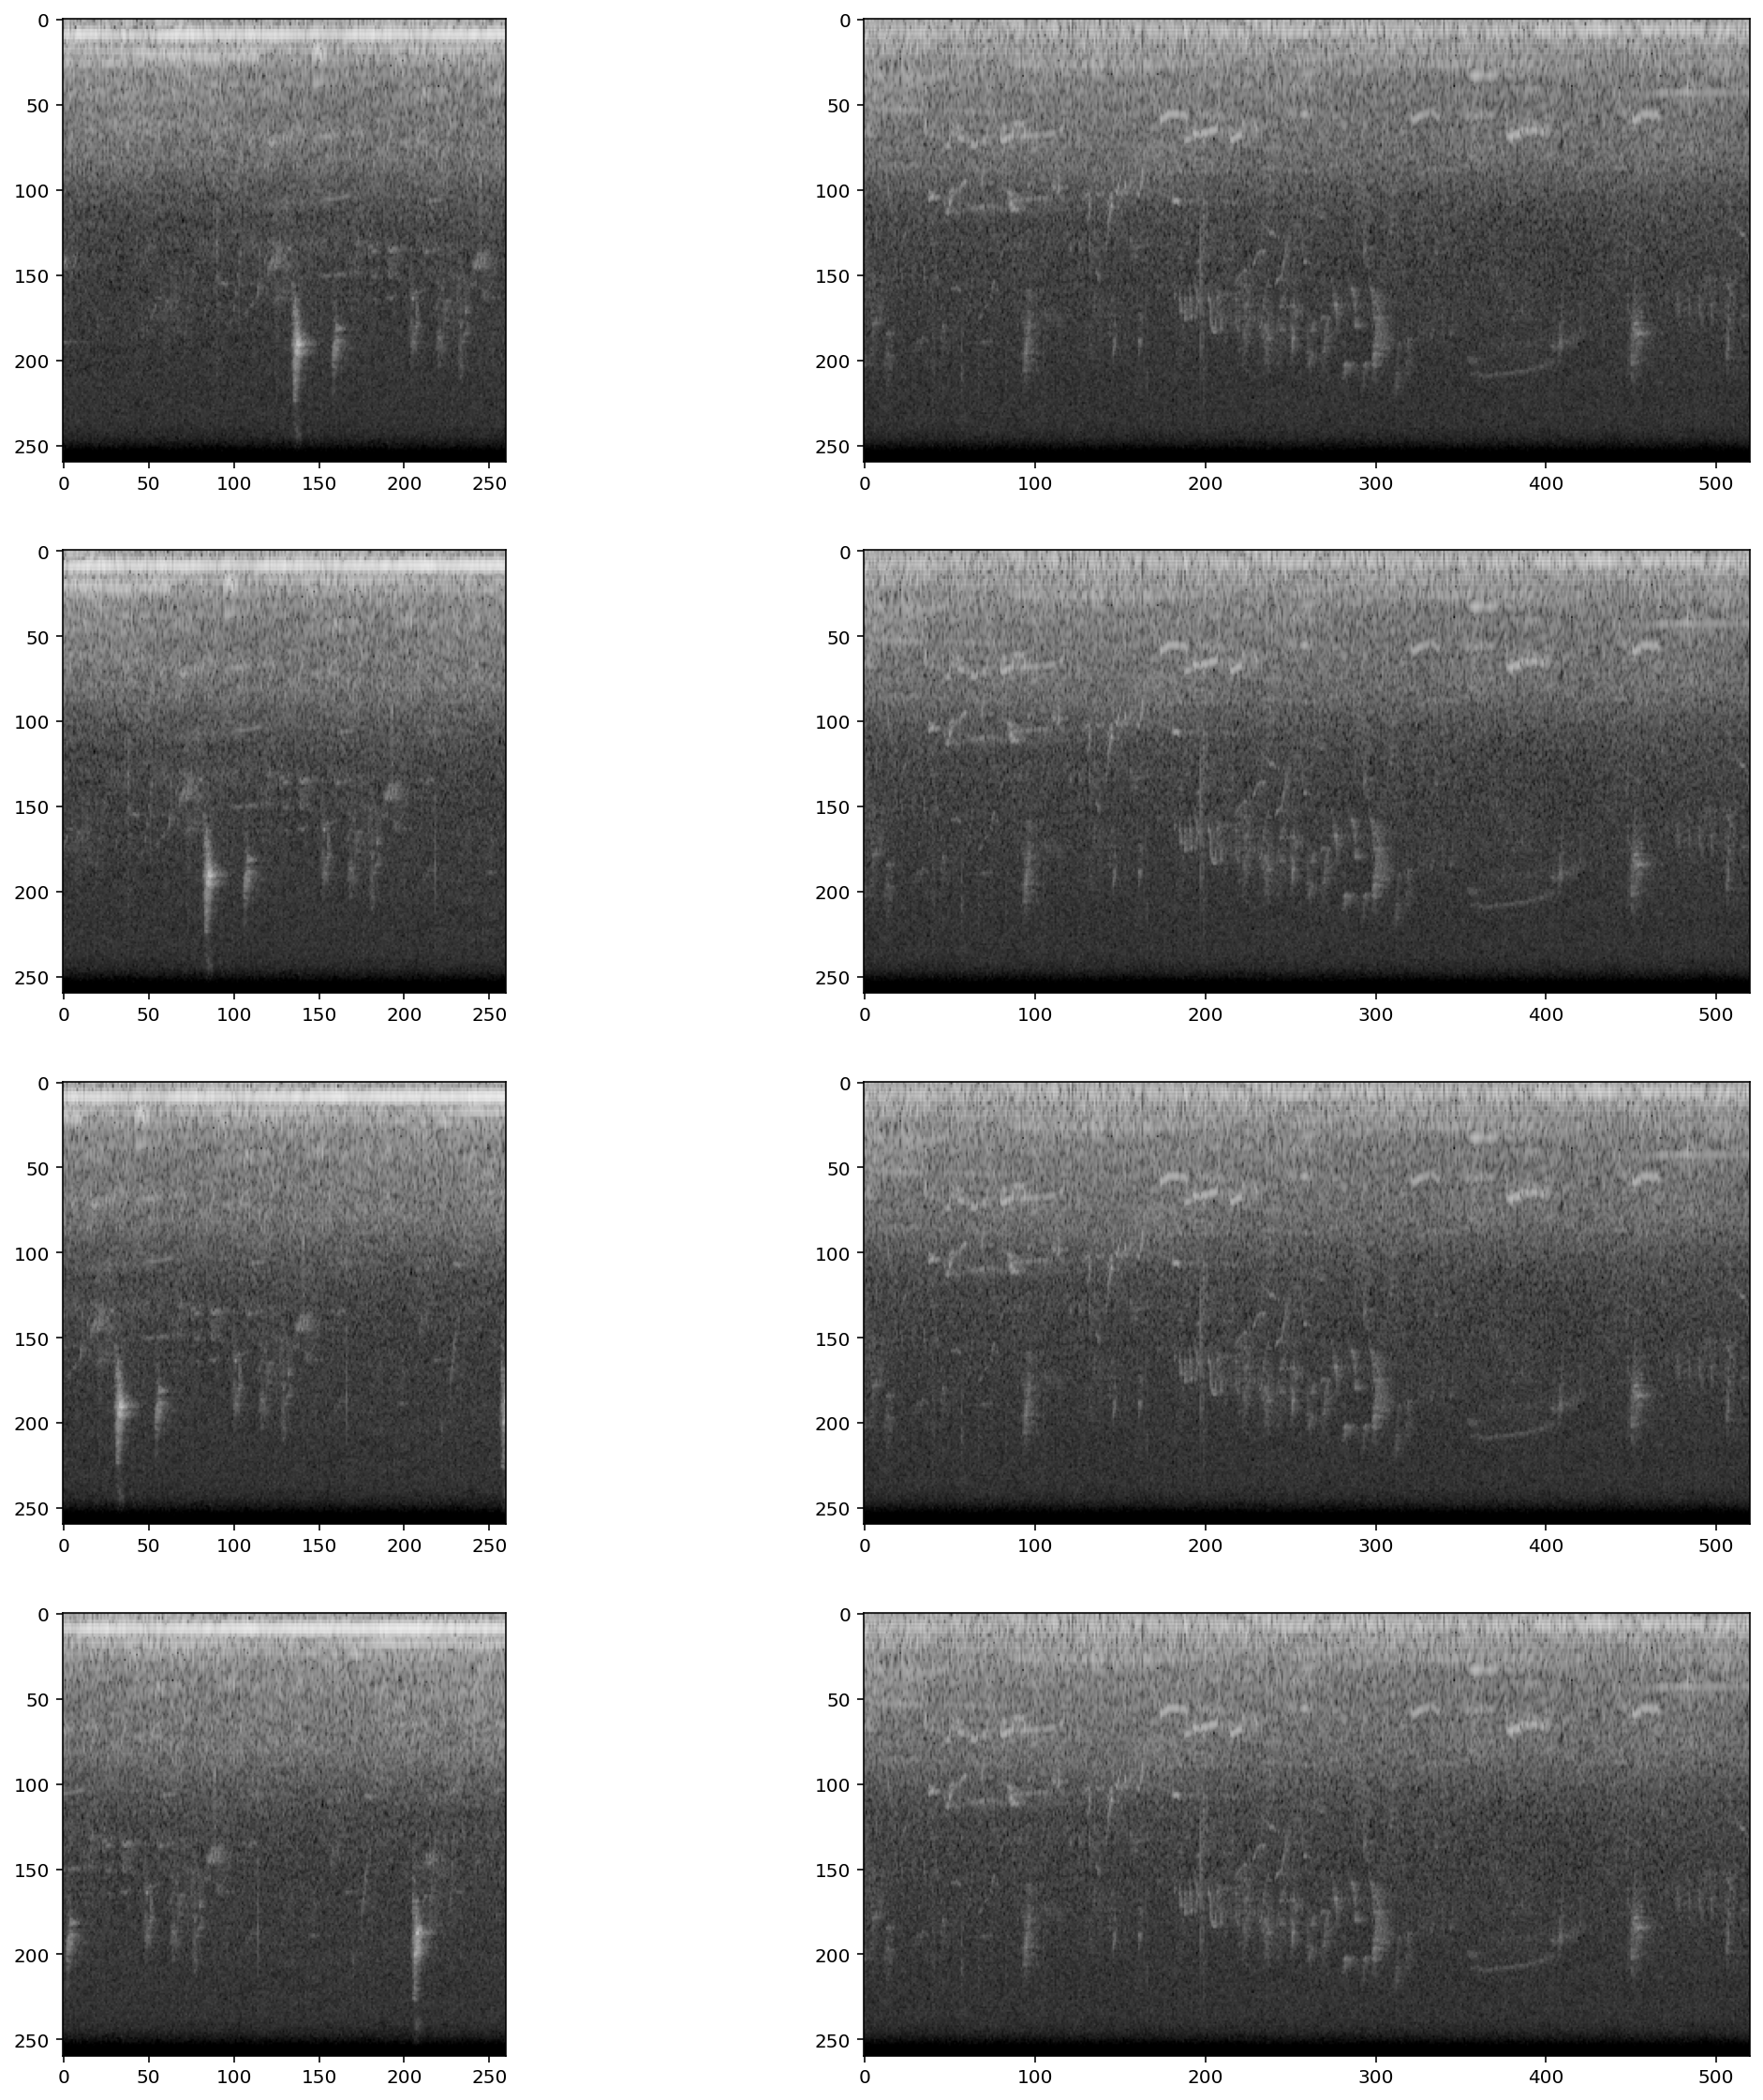

In [116]:
fig = plt.figure(figsize=(25, 20))
gs = fig.add_gridspec(4, 4)
for i, j in enumerate(range(120, 124)):
    b = gen._get_one(j)
    fig_1 = fig.add_subplot(gs[i, 1])
    fig_1.imshow(b["mel_spec"])
    fig_1 = fig.add_subplot(gs[i, 2:])
    plt.imshow(
        np.stack(
            [
                b["long_mel_spec"][:, -260 * 2 :],
                b["long_mel_spec"][:, -260 * 2 :],
                b["long_mel_spec"][:, -260 * 2 :],
            ],
            axis=-1,
        )
    )
plt.show();